<a href="https://colab.research.google.com/github/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/blob/albert/Climate%20Project/albert/notebooks/Hierarchical_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Preparing metadata (setup.py) ... done


In [ ]:
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

def get_saffir_simpson_category(wind_kn):
    # NOTE: observations are rounded to nearest 5 so is this being a bit cheeky??
    if wind_kn <= 82:
        return 1
    if wind_kn <= 95:
        return 2
    if wind_kn <= 112:
        return 3
    if wind_kn <= 136:
        return 4
    return 5

DATASET_URL = "https://raw.githubusercontent.com/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/albert/Climate%20Project/albert/cyclone_data/jtwc/cleaned/full_cleaned.csv"
dset = pd.read_csv(DATASET_URL)
# rename columns
dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
dset['category'] = dset['peak_vmax_kt'].apply(get_saffir_simpson_category)
dset

<ipython-input-2-a512585191a2>:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
<ipython-input-2-a512585191a2>:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()


,timestamp,storm_id,basin,season,season_tc_number,latitude_degrees,longitude_degrees,vmax_kt,peak_vmax_kt,ace,maximum_24h_intensification,tropical_sst,local_sst,local_month_mean,category
0,1982-03-14 06:00:00,1982-N-1,WP,1982.0,1.0,7.1,153.0,15.0,60.0,0.73250,15.0,27.961514,28.082220,28.562027,1
1,1981-10-21 06:00:00,1982-S-2,SI,1982.0,2.0,-8.0,84.6,40.0,85.0,1.18725,25.0,27.240122,28.012896,27.828356,2
2,1982-03-18 06:00:00,1982-N-2,WP,1982.0,2.0,3.8,160.7,25.0,105.0,2.02800,25.0,27.961514,29.003502,28.968107,3
3,1982-03-28 06:00:00,1982-N-3,WP,1982.0,3.0,3.5,156.6,20.0,75.0,0.70650,15.0,27.961514,28.872086,29.140408,1
4,1981-12-05 00:00:00,1982-S-4,SI,1982.0,4.0,-11.9,125.0,45.0,45.0,0.04850,-10.0,27.350914,29.079239,30.004630,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,26.4,154.4,25.0,40.0,0.19675,15.0,27.271444,28.137896,27.757618,1
1807,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,12.2,133.8,20.0,75.0,0.67825,25.0,27.271444,29.645842,29.207080,1
1808,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,8.0,140.4,25.0,40.0,0.10875,15.0,27.271444,29.821840,29.312254,1
1809,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,20.2,166.3,20.0,40.0,0.10600,10.0,27.478075,28.148760,27.703903,1


In [ ]:
standardize = lambda x: (x - x.mean()) / x.std()

BASIN_TO_INDEX = {
    'SI' : 0,
    'SP' : 1,
    'WP' : 2,
}

INDEX_TO_BASIN = {
     0 : 'SI',
     1 : 'SP',
     2 : 'WP',
}

## FOR NUMERICAL STABILITY

s_wind = dset.peak_vmax_kt.std()
wind_bar = dset.peak_vmax_kt.mean()

sst_trop_bar = dset.tropical_sst.mean()
s_sst_trop = dset.tropical_sst.std()

sst_local_bar = dset.local_sst.mean()
s_sst_local = dset.local_sst.std()

dset["tropical_sst_scaled"] = dset.tropical_sst.pipe(standardize)
dset["local_sst_scaled"] = dset.local_sst.pipe(standardize)
dset["peak_wind_scaled"] = dset.peak_vmax_kt.pipe(standardize)
dset['basin_numerical'] = dset.basin.apply(lambda x: BASIN_TO_INDEX[x])
dset

,timestamp,storm_id,basin,season,season_tc_number,latitude_degrees,longitude_degrees,vmax_kt,peak_vmax_kt,ace,maximum_24h_intensification,tropical_sst,local_sst,local_month_mean,category,tropical_sst_scaled,local_sst_scaled,peak_wind_scaled,basin_numerical
0,1982-03-14 06:00:00,1982-N-1,WP,1982.0,1.0,7.1,153.0,15.0,60.0,0.73250,15.0,27.961514,28.082220,28.562027,1,0.716901,-1.405316,-0.704706,2
1,1981-10-21 06:00:00,1982-S-2,SI,1982.0,2.0,-8.0,84.6,40.0,85.0,1.18725,25.0,27.240122,28.012896,27.828356,2,-0.677591,-1.515175,0.041553,0
2,1982-03-18 06:00:00,1982-N-2,WP,1982.0,2.0,3.8,160.7,25.0,105.0,2.02800,25.0,27.961514,29.003502,28.968107,3,0.716901,0.054655,0.638561,2
3,1982-03-28 06:00:00,1982-N-3,WP,1982.0,3.0,3.5,156.6,20.0,75.0,0.70650,15.0,27.961514,28.872086,29.140408,1,0.716901,-0.153602,-0.256951,2
4,1981-12-05 00:00:00,1982-S-4,SI,1982.0,4.0,-11.9,125.0,45.0,45.0,0.04850,-10.0,27.350914,29.079239,30.004630,1,-0.463423,0.174677,-1.152462,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,26.4,154.4,25.0,40.0,0.19675,15.0,27.271444,28.137896,27.757618,1,-0.617043,-1.317085,-1.301714,2
1807,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,12.2,133.8,20.0,75.0,0.67825,25.0,27.271444,29.645842,29.207080,1,-0.617043,1.072582,-0.256951,2
1808,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,8.0,140.4,25.0,40.0,0.10875,15.0,27.271444,29.821840,29.312254,1,-0.617043,1.351489,-1.301714,2
1809,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,20.2,166.3,20.0,40.0,0.10600,10.0,27.478075,28.148760,27.703903,1,-0.217614,-1.299869,-1.301714,2


In [ ]:
NUM_BASINS = 3

## TODO: NEEED LONGER CHAINS.....
# https://betanalpha.github.io/assets/case_studies/divergences_and_bias.html

def centred_hierarchical(
    tropical_sst=None, local_sst=None,
    peak_wind=None, basin_num=None, q=None):

    ## TODO... choice of prior for each quantile
    μ_α = numpyro.sample("μ_α", dist.Normal(np.quantile(peak_wind, q), 0.1))
    σ_α = numpyro.sample("σ_α", dist.HalfCauchy(1))

    μ_β_trop = numpyro.sample("μ_β_trop", dist.Normal(0.0, 5.0))
    σ_β_trop = numpyro.sample("σ_β_trop", dist.HalfCauchy(5))

    μ_β_local = numpyro.sample("μ_β_local", dist.Normal(0.0, 5.0))
    σ_β_local = numpyro.sample("σ_β_local", dist.HalfCauchy(5))

    with numpyro.plate("basins", NUM_BASINS):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β_trop = numpyro.sample("β_trop", dist.Normal(μ_β_trop, σ_β_trop))
        β_local = numpyro.sample("β_local", dist.Normal(μ_β_local, σ_β_local))

        assert α.shape == (NUM_BASINS, ), "alpha shape wrong"

    mu = numpyro.deterministic('mu', α[basin_num] +  β_trop[basin_num] * tropical_sst + β_local[basin_num] * local_sst)
    return numpyro.sample('obs', dist.AsymmetricLaplaceQuantile(loc=mu, scale=1.0,quantile=q), obs=peak_wind)


from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

## try the numpyro reparametrisation as well
reparam_config = {
    "α": LocScaleReparam(0),
    "β_trop": LocScaleReparam(0),
    "β_local": LocScaleReparam(0),
}

reparamed_hierarchical = reparam(
    centred_hierarchical, config=reparam_config)


def noncentred_hierarchical(
    tropical_sst=None, local_sst=None,
    peak_wind=None, basin_num=None, q=None):

    ## TODO... choice of prior for hierarchical model??
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 0.1))
    σ_α = numpyro.sample("σ_α", dist.HalfCauchy(1))

    μ_β_trop = numpyro.sample("μ_β_trop", dist.Normal(0.0, 0.1))
    σ_β_trop = numpyro.sample("σ_β_trop", dist.HalfCauchy(1))

    μ_β_local = numpyro.sample("μ_β_local", dist.Normal(0.0, 0.1))
    σ_β_local = numpyro.sample("σ_β_local", dist.HalfCauchy(1))

    with numpyro.plate("basins", NUM_BASINS):
        α_prime = numpyro.sample("α_prime", dist.Normal(0, 1))
        α = numpyro.deterministic('α', α_prime * σ_α + μ_α)

        β_trop_prime = numpyro.sample("β_trop_prime", dist.Normal(0,1))
        β_trop = numpyro.deterministic('β_trop', β_trop_prime* σ_β_trop + μ_β_trop)


        β_local_prime = numpyro.sample("β_local_prime", dist.Normal(0,1))
        β_local = numpyro.deterministic('β_local', β_local_prime* σ_β_local + μ_β_local)

        assert α.shape == (NUM_BASINS, ), "alpha shape wrong"

    mu = numpyro.deterministic('mu', α[basin_num] +  β_trop[basin_num] * tropical_sst + β_local[basin_num] * local_sst)
    ### OBS IS ACTUALLY THE QUANTILE LOSS... so it's only pseudo-bayesian as it's a bit of a hack..
    with numpyro.plate("data", len(tropical_sst)):
      numpyro.sample('obs', dist.AsymmetricLaplaceQuantile(loc=mu, scale=1.0, quantile=q), obs=peak_wind)


In [ ]:
rng_key = random.PRNGKey(0)

lower = np.arange(0.05, 0.96, 0.1)
# upper = np.arange(0.65, 0.96, 0.1)

# full = np.concatenate((lower))
full = lower
qs   = np.round(full, 2)

NUM_SAMPLES = 10000
NUM_WARMUP = 1000

params = {}

numpyro.enable_x64()

### ADAPT DELTA FOR A HIERARCHICAL MODEL????

for q in qs:
    rng_key, rng_key_ = random.split(rng_key)
    kernel = NUTS(noncentred_hierarchical)
    mcmc = MCMC(kernel, num_chains=4, num_warmup=1000, num_samples=10000, progress_bar=True)
    mcmc.run(
        rng_key_,
        tropical_sst=dset.tropical_sst_scaled.values,
        local_sst=dset.local_sst_scaled.values,
        peak_wind=dset.peak_wind_scaled.values,
        basin_num=dset.basin_numerical.values,
        q=q )
    mcmc_samples = mcmc.get_samples()

    arviz_posterior = az.from_numpyro(
            mcmc,
            # coords=az_coords,
            # dims=az_dims
    )

    params[q] = arviz_posterior
    print(q)
    mcmc.print_summary()
    print()

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.05

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.98      0.37     -0.94     -1.56     -0.37   7865.10      1.00
      α_prime[1]     -0.99      0.38     -0.95     -1.59     -0.39   8062.94      1.00
      α_prime[2]     -0.98      0.37     -0.95     -1.55     -0.36   8080.07      1.00
β_local_prime[0]     -0.12      0.80     -0.11     -1.40      1.22  19866.64      1.00
β_local_prime[1]      0.07      0.86      0.08     -1.35      1.47  23334.06      1.00
β_local_prime[2]      0.10      0.80      0.10     -1.18      1.45  19980.09      1.00
 β_trop_prime[0]     -0.02      0.81     -0.03     -1.44      1.27  20821.30      1.00
 β_trop_prime[1]     -0.05      0.85     -0.05     -1.46      1.34  23722.32      1.00
 β_trop_prime[2]     -0.01      0.80     -0.01     -1.31      1.33  19802.98      1.00
             μ_α     -0.03      0.10     -0.03     -0.19      0.14  27220.50      1.00
       μ_β_local      0.01      0.05 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.15

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.97      0.37     -0.93     -1.55     -0.35   7410.39      1.00
      α_prime[1]     -0.96      0.37     -0.92     -1.53     -0.34   7451.28      1.00
      α_prime[2]     -0.94      0.37     -0.90     -1.52     -0.35   7413.09      1.00
β_local_prime[0]     -0.23      0.78     -0.21     -1.56      1.00  19236.11      1.00
β_local_prime[1]      0.17      0.83      0.18     -1.21      1.52  22774.23      1.00
β_local_prime[2]      0.19      0.79      0.19     -1.09      1.52  21332.06      1.00
 β_trop_prime[0]      0.03      0.81      0.03     -1.28      1.42  19851.13      1.00
 β_trop_prime[1]     -0.01      0.84     -0.01     -1.38      1.41  25139.82      1.00
 β_trop_prime[2]     -0.09      0.81     -0.08     -1.45      1.23  20931.01      1.00
             μ_α     -0.03      0.10     -0.03     -0.20      0.13  29209.63      1.00
       μ_β_local      0.02      0.05 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.25

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.98      0.38     -0.94     -1.57     -0.34   8573.98      1.00
      α_prime[1]     -0.95      0.38     -0.91     -1.53     -0.33   8712.95      1.00
      α_prime[2]     -0.88      0.35     -0.84     -1.43     -0.33   8680.28      1.00
β_local_prime[0]     -0.44      0.73     -0.38     -1.68      0.69  18160.39      1.00
β_local_prime[1]      0.30      0.76      0.29     -0.93      1.61  19958.89      1.00
β_local_prime[2]      0.41      0.73      0.39     -0.77      1.62  18047.48      1.00
 β_trop_prime[0]      0.10      0.81      0.10     -1.22      1.48  21770.03      1.00
 β_trop_prime[1]     -0.02      0.84     -0.02     -1.42      1.37  23270.35      1.00
 β_trop_prime[2]     -0.04      0.82     -0.03     -1.41      1.31  20194.66      1.00
             μ_α     -0.04      0.10     -0.03     -0.21      0.13  26965.11      1.00
       μ_β_local      0.03      0.06 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.35

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -1.01      0.41     -0.96     -1.62     -0.33   8375.21      1.00
      α_prime[1]     -0.95      0.39     -0.91     -1.56     -0.32   8739.33      1.00
      α_prime[2]     -0.68      0.29     -0.64     -1.13     -0.22   9460.90      1.00
β_local_prime[0]     -0.48      0.68     -0.40     -1.65      0.55  17094.27      1.00
β_local_prime[1]      0.42      0.70      0.40     -0.70      1.61  22017.58      1.00
β_local_prime[2]      0.48      0.67      0.44     -0.58      1.62  21170.37      1.00
 β_trop_prime[0]      0.14      0.80      0.14     -1.23      1.44  24289.37      1.00
 β_trop_prime[1]     -0.11      0.83     -0.10     -1.50      1.25  25072.75      1.00
 β_trop_prime[2]      0.08      0.82      0.09     -1.28      1.43  26070.13      1.00
             μ_α     -0.04      0.10     -0.04     -0.21      0.13  27098.92      1.00
       μ_β_local      0.04      0.07 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.45

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.99      0.46     -0.93     -1.69     -0.27  11143.77      1.00
      α_prime[1]     -0.94      0.45     -0.88     -1.63     -0.23  11934.41      1.00
      α_prime[2]     -0.27      0.29     -0.26     -0.76      0.15  13591.67      1.00
β_local_prime[0]     -0.48      0.65     -0.39     -1.61      0.46  15588.30      1.00
β_local_prime[1]      0.55      0.67      0.52     -0.50      1.68  18937.71      1.00
β_local_prime[2]      0.58      0.62      0.53     -0.35      1.62  17785.74      1.00
 β_trop_prime[0]      0.21      0.79      0.21     -1.09      1.52  21939.62      1.00
 β_trop_prime[1]     -0.14      0.82     -0.14     -1.53      1.21  24519.02      1.00
 β_trop_prime[2]      0.15      0.80      0.16     -1.17      1.49  18982.98      1.00
             μ_α     -0.06      0.11     -0.06     -0.23      0.11  15406.87      1.00
       μ_β_local      0.05      0.07 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.55

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]     -0.67      0.52     -0.60     -1.55      0.10  15814.37      1.00
      α_prime[1]     -0.57      0.53     -0.52     -1.47      0.24  17816.54      1.00
      α_prime[2]      0.75      0.56      0.65     -0.08      1.65  13840.55      1.00
β_local_prime[0]     -0.43      0.59     -0.33     -1.44      0.43  15837.51      1.00
β_local_prime[1]      0.84      0.63      0.79     -0.11      1.91  17945.93      1.00
β_local_prime[2]      0.49      0.55      0.45     -0.35      1.42  17231.78      1.00
 β_trop_prime[0]      0.38      0.78      0.38     -0.90      1.69  24238.27      1.00
 β_trop_prime[1]     -0.17      0.79     -0.15     -1.53      1.09  26304.05      1.00
 β_trop_prime[2]      0.28      0.76      0.29     -0.98      1.56  20152.65      1.00
             μ_α     -0.02      0.09     -0.02     -0.16      0.12  18462.25      1.00
       μ_β_local      0.05      0.08 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.65

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]      0.26      0.34      0.24     -0.26      0.84  16170.13      1.00
      α_prime[1]      0.14      0.37      0.14     -0.45      0.76  17323.18      1.00
      α_prime[2]      1.32      0.58      1.24      0.34      2.17  12759.38      1.00
β_local_prime[0]     -0.51      0.52     -0.41     -1.37      0.24  14203.23      1.00
β_local_prime[1]      0.97      0.57      0.91      0.11      1.89  15365.93      1.00
β_local_prime[2]      0.46      0.48      0.42     -0.26      1.26  17589.62      1.00
 β_trop_prime[0]      0.59      0.71      0.57     -0.49      1.85  21157.42      1.00
 β_trop_prime[1]     -0.20      0.72     -0.14     -1.42      0.95  22869.70      1.00
 β_trop_prime[2]      0.47      0.69      0.47     -0.69      1.61  21133.53      1.00
             μ_α      0.05      0.10      0.05     -0.11      0.21  17489.35      1.00
       μ_β_local      0.04      0.09 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.75

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]      0.65      0.29      0.61      0.18      1.10   7862.29      1.00
      α_prime[1]      0.58      0.29      0.54      0.11      1.01   9838.20      1.00
      α_prime[2]      1.28      0.52      1.23      0.44      2.09   5753.18      1.00
β_local_prime[0]     -0.45      0.56     -0.35     -1.37      0.37  14573.48      1.00
β_local_prime[1]      0.91      0.61      0.85     -0.01      1.92  20082.12      1.00
β_local_prime[2]      0.47      0.51      0.43     -0.29      1.34  16691.74      1.00
 β_trop_prime[0]      0.63      0.71      0.62     -0.49      1.85  20018.60      1.00
 β_trop_prime[1]     -0.25      0.71     -0.20     -1.49      0.86  22496.83      1.00
 β_trop_prime[2]      0.41      0.67      0.40     -0.69      1.52  19909.46      1.00
             μ_α      0.04      0.10      0.04     -0.12      0.21  17980.52      1.00
       μ_β_local      0.04      0.09 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.85

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]      0.83      0.33      0.79      0.28      1.32   7741.86      1.00
      α_prime[1]      0.77      0.31      0.73      0.27      1.24   8182.10      1.00
      α_prime[2]      1.24      0.48      1.19      0.46      1.98   7358.95      1.00
β_local_prime[0]     -0.33      0.61     -0.24     -1.32      0.64  16188.62      1.00
β_local_prime[1]      0.85      0.73      0.83     -0.23      2.15  15397.98      1.00
β_local_prime[2]      0.36      0.58      0.32     -0.56      1.34  16666.58      1.00
 β_trop_prime[0]      0.24      0.80      0.25     -1.13      1.55  21746.30      1.00
 β_trop_prime[1]      0.08      0.85      0.10     -1.35      1.45  25123.63      1.00
 β_trop_prime[2]      0.21      0.78      0.22     -1.07      1.49  20781.28      1.00
             μ_α      0.03      0.10      0.03     -0.14      0.19  28677.94      1.00
       μ_β_local      0.05      0.08 

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

0.95

                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      α_prime[0]      0.89      0.34      0.86      0.35      1.43   7011.50      1.00
      α_prime[1]      0.89      0.34      0.86      0.34      1.43   6904.76      1.00
      α_prime[2]      1.18      0.44      1.14      0.47      1.88   6776.83      1.00
β_local_prime[0]     -0.23      0.74     -0.19     -1.49      0.96  23821.56      1.00
β_local_prime[1]      0.48      0.83      0.51     -0.93      1.82  22796.55      1.00
β_local_prime[2]      0.31      0.71      0.29     -0.84      1.51  22393.63      1.00
 β_trop_prime[0]      0.14      0.78      0.17     -1.21      1.38  19932.71      1.00
 β_trop_prime[1]      0.33      0.82      0.35     -1.00      1.74  24166.81      1.00
 β_trop_prime[2]      0.34      0.76      0.35     -0.94      1.60  21751.32      1.00
             μ_α      0.02      0.10      0.02     -0.14      0.19  31072.53      1.00
       μ_β_local      0.04      0.08 

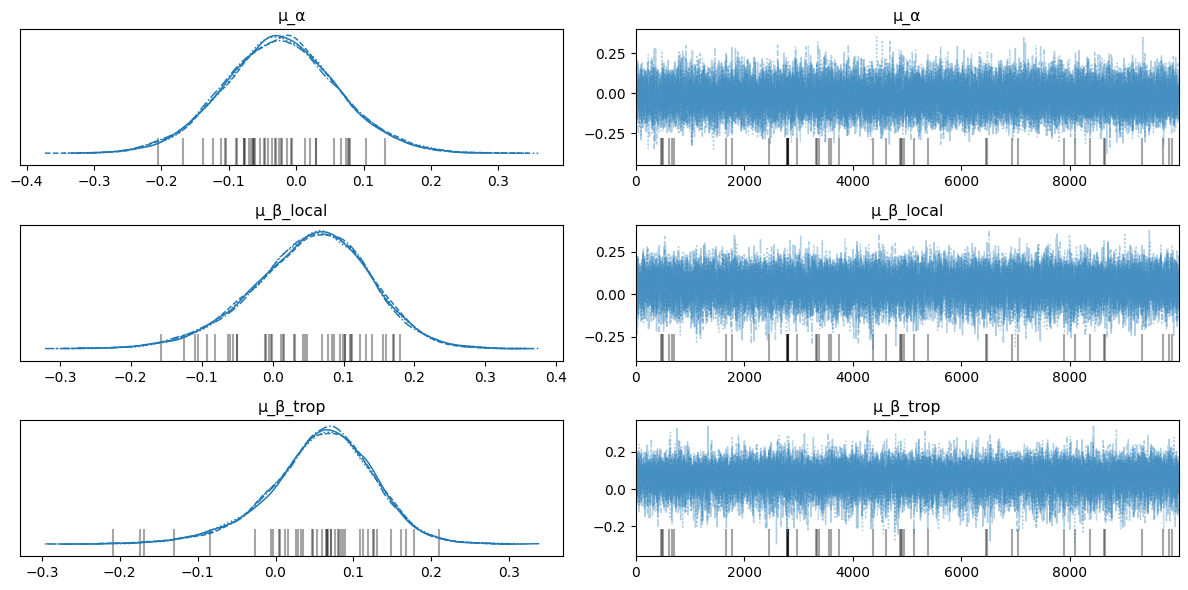

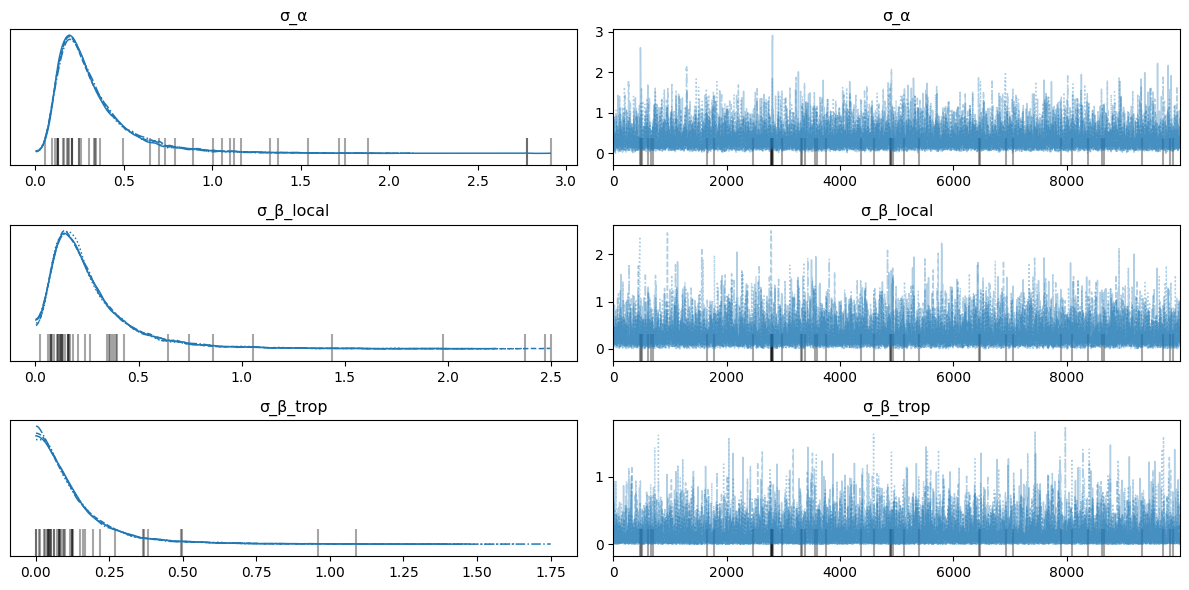

In [ ]:
CHOSEN_QUANTILE = 0.55


az.plot_trace(params[CHOSEN_QUANTILE], var_names=['μ_α', 'μ_β_local', 'μ_β_trop']);
plt.tight_layout()
plt.show()

az.plot_trace(params[CHOSEN_QUANTILE], var_names=['σ_α', 'σ_β_local', 'σ_β_trop']);
plt.tight_layout()
plt.show()

## The 'Funnel' distribution and associated problems.

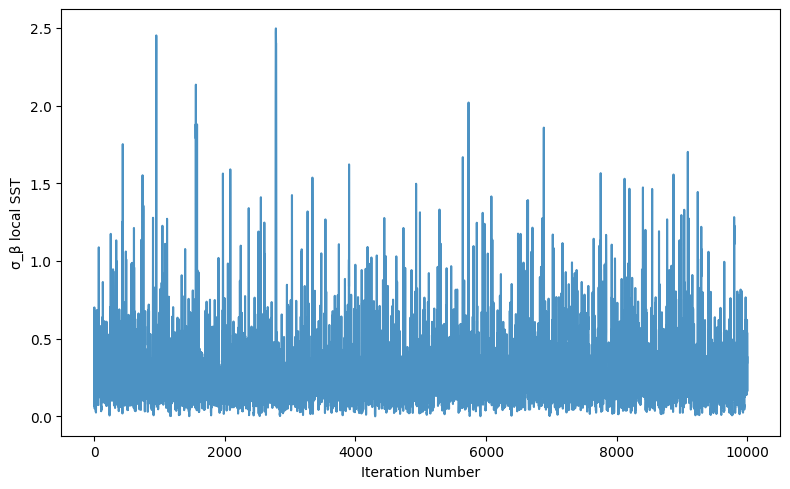

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(params[CHOSEN_QUANTILE]['posterior']['σ_β_local'].sel(chain=2).to_series(), alpha=.8);
ax.set_ylabel('σ_β local SST')
ax.set_xlabel('Iteration Number')
fig.tight_layout()
fig.savefig('./sigma_local_chain_centred.png')
plt.show()


            β Local SST South Indian  σ β(Local SST)  divergent
chain draw                                                     
0     0                    -0.108517       -1.489528      False
      1                     0.040181       -1.455846      False
      2                     0.004238       -2.362166      False
      3                     0.059959       -2.584577      False
      4                     0.045903       -2.248206      False
...                              ...             ...        ...
3     9995                 -0.162425       -1.451289      False
      9996                 -0.087944       -2.036564      False
      9997                 -0.004664       -1.248855      False
      9998                 -0.061644       -2.201608      False
      9999                 -0.081756       -1.320846      False

[40000 rows x 3 columns]


<ipython-input-8-ad91ffe11d85>:12: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  g = sns.jointplot(data = df, x=x_label, y=y_label, hue='divergent', ax=ax);


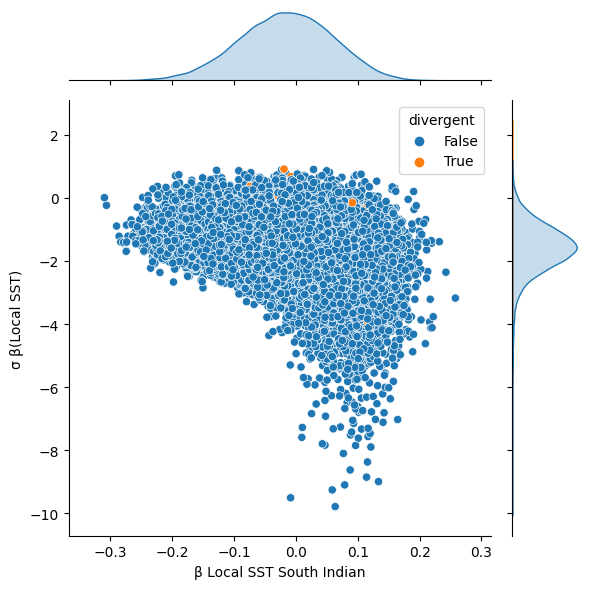

In [ ]:
### PLOT DIVERGENT TRANSITIONS.....
x = params[CHOSEN_QUANTILE]['posterior']['β_local'].sel(β_local_dim_0=0).to_series()
y = params[CHOSEN_QUANTILE]['posterior']['σ_β_local'].to_series()
is_div = params[CHOSEN_QUANTILE]['sample_stats']['diverging'].to_series()

x_label = 'β Local SST South Indian'
y_label = 'σ β(Local SST)'

df = pd.DataFrame({x_label: x, y_label: np.log(y), 'divergent': is_div})
print(df)

g = sns.jointplot(data = df, x=x_label, y=y_label, hue='divergent', ax=ax);
# g.set_axis_labels('β for Tropical SST, SP Basin', 'σ_β Tropical SST', fontsize=16)

g.figure.tight_layout()
g.figure.savefig('./local_sigma_beta_pairplot_centred.png')
plt.show()



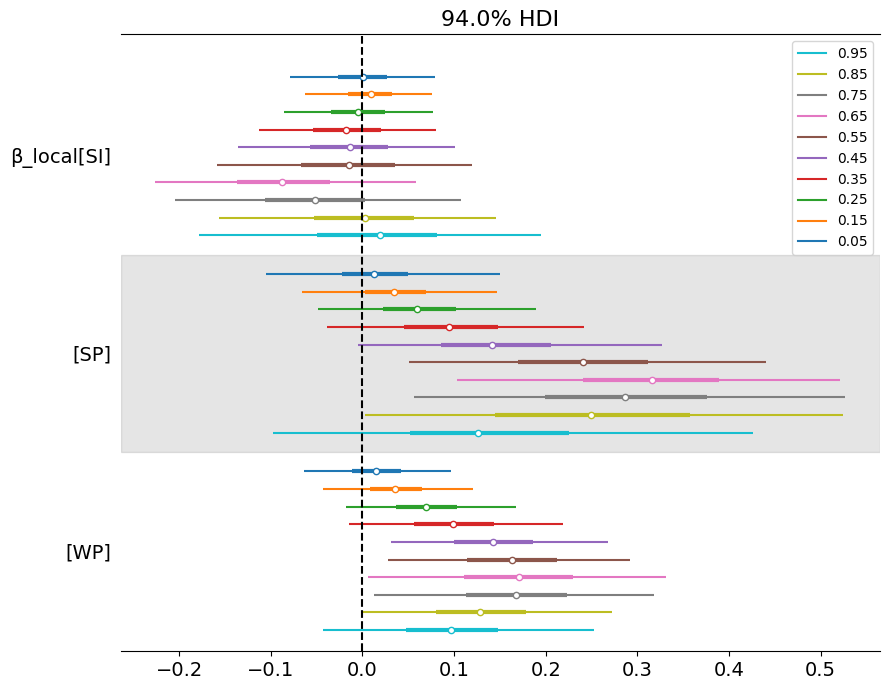

In [ ]:
def index_to_basin_mapped(indices):
  vectorized = np.vectorize(lambda ind: INDEX_TO_BASIN[ind])
  return vectorized(indices)

local_posteriors = [params[q]['posterior']['β_local'] for q in qs]
local_posteriors = [post.assign_coords(β_local_dim_0 = index_to_basin_mapped(post.β_local_dim_0)) for post in local_posteriors]


fig, axs = plt.subplots(figsize=(9, 7))
axs = az.plot_forest(local_posteriors,
                model_names = qs,
                           kind='forestplot',
                           combined=True,
                            ax=axs)

axs[0].axvline(0, color="black", linestyle="dashed")

fig.tight_layout()
plt.show()
fig.savefig('hdi_local_beta.png')



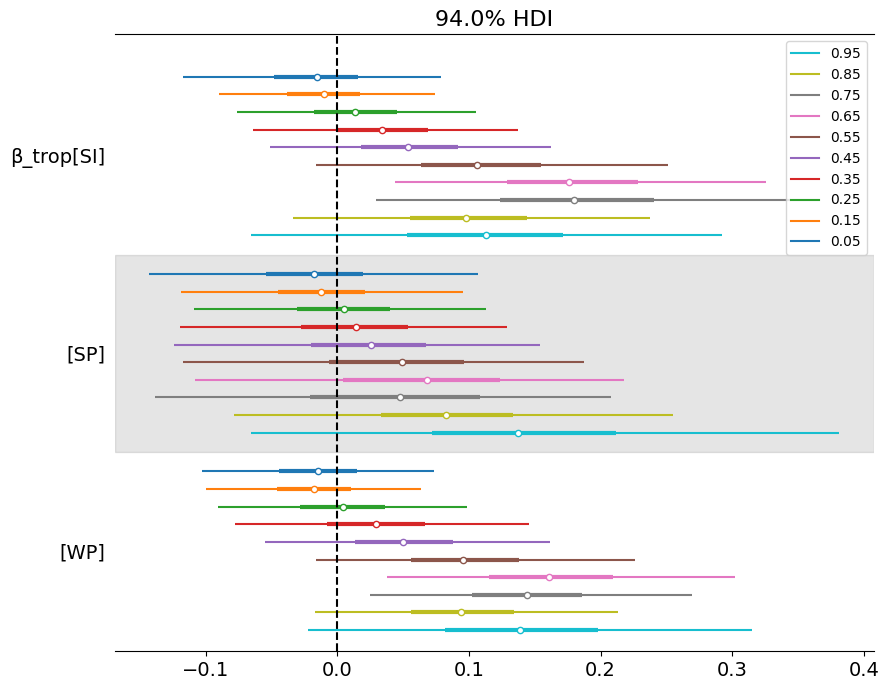

In [ ]:
trop_posteriors = [params[q]['posterior']['β_trop'] for q in qs]
trop_posteriors = [post.assign_coords(β_trop_dim_0 = index_to_basin_mapped(post.β_trop_dim_0)) for post in trop_posteriors]


fig, axs = plt.subplots(figsize=(9, 7))

axs = az.plot_forest(trop_posteriors,
                     model_names = qs,
                     kind='forestplot',
                     ax = axs,
                     combined=True)

axs[0].axvline(0, color="black", linestyle="dashed")

fig.tight_layout()
plt.show()
fig.savefig('hdi_tropical_beta.png')

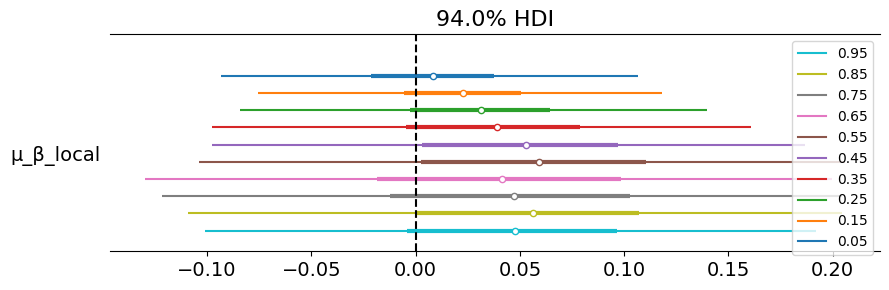

In [ ]:
global_mean_posteriors = [params[q]['posterior']['μ_β_local'] for q in qs]

fig, axs = plt.subplots(figsize=(9, 3))
axs = az.plot_forest(global_mean_posteriors,
                     model_names = qs,
                     kind='forestplot',
                     combined=True,
                     ax=axs)

axs[0].axvline(0, color="black", linestyle="dashed")
fig.tight_layout()
plt.show()
fig.savefig('hdi_local_beta_hyper.png')

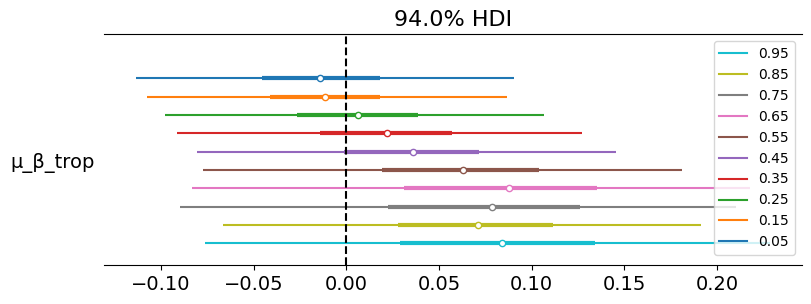

In [ ]:
global_mean_posteriors = [params[q]['posterior']['μ_β_trop'] for q in qs]

fig, axs = plt.subplots(figsize=(9, 3))
axs = az.plot_forest(global_mean_posteriors,
                     model_names = qs,
                     kind='forestplot',
                     combined=True,
                     ax=axs)

axs[0].axvline(0, color="black", linestyle="dashed")

fig.savefig('hdi_tropical_beta_hyper.png')

In [ ]:
# JUST HAVE TO USE OUR OWN PREDICTIVE

# pred = params[0.95].posterior_predictive['mu']
# print(pred[0][0][1])
# print(pred[1][0][1])
# print(pred[2][0][1])
# print(pred[3][0][1])
# print(pred[0][1][1])
# print(pred[0][2][1])
# print(pred[0][3][1])
# print(pred[0][4][1]) ## WHY IS THERE SO MUCH VARIATION????

## predicting negative wind speed.....????
## these are wayyyyy tooo wide
# pred[0][0][18] * s_wind + wind_bar

# def predict(rng_key, post_samples, model, *args, **kwargs):
#     model = handlers.seed(handlers.condition(model, post_samples), rng_key)
#     model_trace = handlers.trace(model).get_trace(*args, **kwargs)
#     return model_trace["mu"]["value"]


# # # vectorize predictions via vmap
# predict_fn = vmap(
#     lambda rng_key, samples: predict(
#         rng_key, samples, noncentred_hierarchical,
#         tropical_sst = np.array([0.0]),
#         local_sst    = np.array([0.5]),
#         basin_num    = np.array([1]),
#         q            = 0.55
#     )
# )

# v = predict_fn(random.split(rng_key_, 40000), mcmc_samples)
# v

# obs_dim_0 -> index in dataset.... corresponds to arguments...

# for n in np.random.default_rng(0).integers(dset.shape[0], size=100):
#     plt.plot(
#         dset.tropical_sst_scaled.values[n], post_pred_y[1], ".", color="C0", alpha=0.1, label=label)
#     label = None
# plt.legend();

In [ ]:
HISTORICAL_RESAMPLE_URL = "https://raw.githubusercontent.com/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/albert/Climate%20Project/albert/cyclone_data/jtwc/cleaned/historical_generated_cyclones_cmip.csv"
resample_dset = pd.read_csv(HISTORICAL_RESAMPLE_URL)
# rename columns
resample_dset.columns = resample_dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
resample_dset

<ipython-input-14-8cb2027a1a18>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  resample_dset.columns = resample_dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
<ipython-input-14-8cb2027a1a18>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  resample_dset.columns = resample_dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()


,timestamp,lat,lon,basin,month,month_name,tropical_sst,local_sst
0,1982-04-08 00:00:00,4.0,176.0,WP,4,Apr,27.852587,28.392761
1,1982-05-04 00:00:00,14.8,115.0,WP,5,May,27.853258,29.105080
2,1982-05-04 00:00:00,4.8,174.8,WP,5,May,27.853258,28.814432
3,1982-07-01 00:00:00,15.4,112.2,WP,7,Jul,27.853996,28.770517
4,1982-07-05 00:00:00,18.1,138.5,WP,7,Jul,27.853996,29.053247
...,...,...,...,...,...,...,...,...
1172,2014-10-21 00:00:00,13.4,131.4,WP,10,Oct,28.277517,29.666586
1173,2014-10-27 00:00:00,15.8,165.8,WP,10,Oct,28.277517,28.998026
1174,2014-10-28 00:00:00,13.0,126.0,WP,10,Oct,28.277517,29.602152
1175,2014-11-14 00:00:00,7.8,159.7,WP,11,Nov,28.276270,29.839910


In [ ]:
resample_dset["tropical_sst_scaled"] = resample_dset.tropical_sst.pipe(standardize)
resample_dset["local_sst_scaled"] = resample_dset.local_sst.pipe(standardize)
resample_dset['basin_numerical'] = resample_dset.basin.apply(lambda x: BASIN_TO_INDEX[x])

# HAVE TO DO EACH QUANTILE AT A TIME FOR POSTERIOR PREDICTIVE


## TODO/FIX:
## - predict distribution for each cyclone
## - sample randomly from those predictions
## - ALL QUANTILES SIMULTANEOUSLY
## - HOW DO WIND SPEED DISTRIBUTIONS LOOK???
## - MATCH PREDICTIVE AND HISTORICAL MODELS: SSTS AT GENESIS CONTROLLED, COMPARE TC WIND DISTRIBUTION...
###     1. local 2. tropical 3. local minus tropical
## -partial pooling
## REDO BASINS

## Differences in CMIP... ? EL NINO AND LA NINA CHAOTIC
